In [2]:
import numpy as np
from autograd.scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as plt
import itertools as iter
import cmath
%matplotlib inline

### Defining machine parameters as python dictionaries
You can create your own machine dictionaries

In [3]:
#Defining Machine parameters 

mach_mc = {"rs": 0.009, "rr": 0.007, "lh": 4.14, "ls": 4.21, "lr": 4.21, "tmech":509.6}

mach_mb = {"rs": 0.0185, "rr": 0.0132, "lh": 3.81, "ls": 3.9, "lr": 3.9, "tmech":397.31}

mach_ma = {"rs": 0.015, "rr": 0.04, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

mach_BM = {"rs": 0.0426, "rr": 0.02113, "lh": 2.252, "ls": 2.252+0.078, "lr": 2.252+0.1052, "tmech":200.}

###  Machine parameters
We use machine dictionaries to calculate the various parameters used in space vector based machine model This function is called mach_para(dict)

This calculates all parameters needed for the machine model with state variables 
$$\vec{i}_s, \vec{\psi}_r$$

In [4]:
def mach_para(dict):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = dict["rs"]
    rr = dict["rr"]
    lh = dict['lh']
    ls = dict['ls']
    lr = dict['lr']
    sig= 1-(lh*lh)/(lr*ls)
    kr=lh/lr
    sigls=sig*ls
    tr=lr/rr
    rk=(rs+(kr)*(kr)*rr)
    tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = dict['tmech']
#     print("lh = {0:1.3f}".format(lh))
    return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech

mach_para(mach_mc)

(0.009,
 0.007,
 4.14,
 4.21,
 4.21,
 0.03297769703398212,
 0.9833729216152018,
 601.4285714285714,
 0.015769156120762125,
 8.804282451758413,
 509.6)

### Induction motor dynamics
#### Dynamic model of Induction Machine
To study the performance of Induction machine by simulation, we will need to develop the dynamic model of the induction machine that include the rotor inertia dynamics. We will choose 5 state variables. In effect, we are using only 3 state variables. However, out of the 3 state variables, the first 2 are complex state variables. Hence for simulation, we will decompose them into real and imaginary parts. These state variables as $i_{s\alpha}, i_{s,\beta}$,$\psi_{r,\alpha}, \psi_{r,\beta}$ and $\omega$. The differential equations are given as

\begin{align}
\frac{di_{s\alpha}}{d\tau}&= -\frac{1}{\tau_k}i_{s\alpha} + \frac{k_r}{\sigma l_s}\frac{1}{\tau_r}\psi_{s\alpha} + \frac{k_r}{\sigma ls}\omega\psi_{r\beta} + \frac{v_{s\alpha}}{\sigma ls}\\
\frac{di_{s\beta}}{d\tau}&= -\frac{1}{\tau_k}i_{s\beta} + \frac{k_r}{\sigma l_s}\frac{1}{\tau_r}\psi_{s\beta} - \frac{k_r}{\sigma ls}\omega\psi_{r\alpha} + \frac{v_{s\beta}}{\sigma ls}\\
\frac{d\psi_{r\alpha}}{d\tau}&= - \omega\psi_{r\beta} -\frac{1}{\tau_r}\psi_{r\alpha} +\frac{l_h}{\tau_r}i_{s\alpha}\\
\frac{d\psi_{r\beta}}{d\tau}&= \omega\psi_{r\alpha} -\frac{1}{tau_r}\psi_{r\beta} +\frac{l_h}{\tau_r}i_{s\beta}\\
\frac{\omega}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_l\right]
\end{align}


### Converting dynamic equations at a partcular point into steady state
\begin{align}
\vec{v}_s &= r_s\vec{i}_s + \frac{d\vec{\psi}_s}{d\tau}\\
0 &= r_r\vec{i}_r + \frac{d\vec{\psi}_r}{d\tau} - j\omega\vec{\psi}_r \\
\frac{d\omega}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_l\right]
\end{align}
becomes

\begin{align}
\vec{v}_s &= r_s\vec{i}_s + \frac{d|\psi_s|}{d\tau}e^{j\omega_s\tau} + j\omega_s\vec{\psi}_s\\
\end{align}
as the magnitue does not change, we get 
\begin{align}
\vec{v}_s &= r_s\vec{i}_s  + j\omega_s\vec{\psi}_s\\
\vec{v}_s &= r_s\vec{i}_s + j\omega_s(\sigma l_s\vec{i}_s + k_r\vec{\psi}_r) \\
\vec{v}_s &= r_s\vec{i}_s + j\omega_s\sigma l_s\vec{i}_s + j\omega_sk_r\vec{\psi}_r
\end{align}

Similarly rotor equation becomes
\begin{align}
0 &= r_r\vec{i}_r + \frac{d|\psi_r|e^{j\omega_s\tau}}{d\tau} - j\omega\vec{\psi}_r \\
0 &= r_r\vec{i}_r +  j\omega_r\vec{\psi}_r \\
0 &= \frac{r_r}{l_r}\left(\vec{\psi}_r - l_h\vec{i}_s \right) + j\omega_r\vec{\psi}_r \\
l_h\vec{i}_s &= (1 + j\omega_r\tau_r)\vec{\psi}_r
\end{align}

In rotor field coordinate system we can write the rotor equation as 

\begin{align}
l_h(i_{sd} + ji_{sq}) &= (1 + j\omega_r\tau_r)\psi_r \\
l_hi_{sd} &= \psi_r \\
l_hi_{sq}  &= \omega_r\tau_r\psi_r
\end{align}


## Function for machine model dynamic

In [5]:
def Im_dynamic(X,t,paraIM2):
    isa =X[0]
    isb = X[1]
    psira  = X[2]
    psirb  = X[3]
    w =      X[4]
    #paas on the machine parameters using params option
    vsa,vsb,ml,rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech  = paraIM2
    #
    me = kr*(psira*isb - psirb*isa) 
    #define the RHS of the ODE
    disadt = -(1/tk)*isa + (kr/(sig*ls*tr))*psira + (kr/(sig*ls))*w*psirb + vsa/(sig*ls)
    disbdt = -(1/tk)*isb + (kr/(sig*ls*tr))*psirb - (kr/(sig*ls))*w*psira + vsb/(sig*ls)
    dpsiradt = -w*psirb -(1/tr)*psira + (lh/tr)*isa
    dpsirbdt = +w*psira -(1/tr)*psirb + (lh/tr)*isb
    dwdt = (1/tmech)*(me - ml)
    return [disadt,disbdt,dpsiradt,dpsirbdt,dwdt]


## Rotor model based Rotor flux estimator

In [6]:
def rotor_model(X,t,paramsmodel):
    psira = X[0]
    psirb = X[1]
    lh,tr,w,isa,isb =paramsmodel
    
    dpsiradt = -w*psirb -(1/tr)*psira + (lh/tr)*isa
    dpsirbdt = +w*psira -(1/tr)*psirb + (lh/tr)*isb
    return [dpsiradt,dpsirbdt]
    

In [7]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)*dt
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]

    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)*dt
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

## Time domain simulation
1. To simulate the motor dynamic we will create a time series with real time in [s], with very small time step say 1e-6 [s]. Since the equations are in [p.u] will pass on normalized time when solving ODE
2. We will create another time base say 512[$\mu$s] to simulate the digital control system. So all values here will be updates in the sampling period 


In [8]:
tend = 4#s
tinc = 3.183098861837907e-05
rt = np.arange(0,tend,tinc)
#Solution variables and control variab;es
u = np.zeros((len(rt),2)) #array for the voltage - u[0][0] - vsalpha(0) u[0][1] - vsbeta(0)
mla = np.zeros(len(rt))  #load torque array
soln = np.zeros((len(rt),5)) #array to store the solution values 
solm = np.zeros((len(rt),2))
print(len(rt), len(u), len(mla), len(soln))
print(np.shape(u))

125664 125664 125664 125664
(125664, 2)


In [9]:
#generating voltages
#defining the voltage and torque steps
w_R = 2*np.pi*50
a = 0.5
for ii, item in enumerate(rt):
    if(item < 3e-3):
        u[ii] = [0,0]
        mla[ii] = 0.5
    elif(item <= 10e-3):
        u[ii] = [a*np.cos(a*w_R*item), a*np.sin(a*w_R*item)] #vbyf = constant acheived 
        mla[ii] = 0.3  #
    else:
        u[ii] = [a*np.cos(a*w_R*item), a*np.sin(a*w_R*item)]
        mla[ii] = 0.2  #Torque changed to 1.0
#set machine parameters
rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
print(rs,rk)

0.0185 0.03109779881656805


### Setting the PI controller using magnitude optimum

In [10]:
T_s = 3.183098861837907e-05#512e-6#sampling time
########-----------------------------------
V_LL = 400#V
Vpnpeak = np.sqrt(2)*V_LL/np.sqrt(3)
I_LL = 10.4#A
V_DC = np.sqrt(2)*V_LL#V Peak value of line to line voltage
print("V_DC", V_DC)
T_eq = 1.5*T_s
# T_eq = T_s
#Normalized time constant
tau_eq = T_eq*w_R
k_c = V_DC/(2*Vpnpeak)
#
k_is = 1/rk
k_im = k_c*1/rk
ac = 4.0
T_i = tk
T_i = tau_eq*ac**2
print(tk, tau_eq, k_im)
# k_pi = tk/(2*k_im*tau_eq)
k_pi = tk/(0.8*ac*k_im*tau_eq)
print(ac,tk,tau_eq)
Kparams = [k_pi,T_i]
Kparams2 = [k_pi,T_i, -1.0,1.0]
print(k_pi, T_i, k_im)
rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
#----------------------------


V_DC 565.685424949238
5.721404205248259 0.015 27.848447052241013
4.0 5.721404205248259 0.015
4.280164014857703 0.24 27.848447052241013


In [11]:

usa = np.zeros(len(rt))
usb = np.zeros(len(rt))
sol1 = np.zeros((len(rt),5))
sol2 = np.zeros((len(rt),2))
FCangle = np.zeros(len(rt))
# Field coordinate currents
cosdelta = np.zeros(len(rt))
sindelta = np.zeros(len(rt))
isd = np.zeros(len(rt))
isq = np.zeros(len(rt))
usd = np.zeros(len(rt))
usq = np.zeros(len(rt))
eid = np.zeros(len(rt))
eiq = np.zeros(len(rt))

#Creating reference values for isd and isq
isdrefval = 1/lh
isdref = np.zeros(len(rt))
isqref = np.zeros(len(rt))

isqref1 = 0
isqref2 = 0.5
isqref3 = -0.35
for ii, item in enumerate(rt):
    isdref[ii] = isdrefval
    if (item >= 15e-3):
        isqref[ii] = isqref3
    elif(item >= 5e-3):
        isqref[ii]= isqref2
    else:
        isqref[ii]=isqref1




psird = np.zeros(len(rt))
psirq = np.zeros(len(rt))

mL = 0.0
me = np.zeros(len(rt))
# x0 = [0.0,0.0,1.0,0,ws]
rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)




In [12]:
ws = 0.4
#Initialize
X0 = [0.3,0.0,1.0,0.0,ws] #setting the inital conditions 
X0m = [1.0,0] 
# ODE solver parameters
abserr = 1.0e-5
relerr = 1.0e-3

for ii, item in enumerate(rt):
    if ii > 0:
        eid[ii] = isdref[ii-1] - isd[ii-1]
        PIed = [eid[ii],eid[ii-1]]
        usd[ii] = PIcon(PIed, usd[ii-1], w_R*tinc,Kparams) #+ ws*sig*ls*isq[ii-1]
#         usd[ii] = PIconwithLim(PIed,usd[ii-1],tinc,Kparams2)
        eiq[ii] = isqref[ii-1] - isq[ii-1]
        PIeq = [eiq[ii],eiq[ii-1]]
        usq[ii] = PIcon(PIeq, usq[ii-1], w_R*tinc,Kparams) #- ws*sig*ls*isd[ii-1]
#         usq[ii] = PIconwithLim(PIeq,usq[ii-1],tinc,Kparams2)
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
    #vector control transformation 
    usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
    usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]
    #------------------------------------------------------------------------------------
    #Model of the induction motor full
    params = [usa[ii],usb[ii],0,rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech] #desired frequency , voltage components, load torque
    #call odeint(dydt, Initial condition, [0,tinc], parameters)
    solx = odeint(Im_dynamic,X0, [0,w_R*tinc], args = (params,), atol = abserr, rtol = relerr)
    X0 = solx[-1] #
    sol1[ii] = solx[-1] #
    # lh,tr,w,isa,isb
    #estimator uses only the variables that I can measure
    paramsmodel = [lh,tr,sol1[ii,4],sol1[ii,0],sol1[ii,1],]
    soly = odeint(rotor_model,X0m, [0,w_R*tinc], args = (paramsmodel,), atol = abserr, rtol = relerr)
    X0m = soly[-1]
    sol2[ii] = soly[-1]
    #----------------------------------------
    psircomp = complex(sol2[ii][0], sol2[ii][1])
    FCangle[ii] = np.arccos(sol2[ii][0]/np.abs(psircomp))
    cosdelta[ii] = sol2[ii][0]/np.abs(psircomp)
    sindelta[ii] = sol2[ii][1]/np.abs(psircomp)
    #Coordinate transformation 
    #Convert stator coordinate current to field coordinates
    isd[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
    isq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
    psird[ii] = sol2[ii][0]*cosdelta[ii] + sol2[ii][1]*sindelta[ii]
    psirq[ii] = sol2[ii][1]*cosdelta[ii] - sol2[ii][0]*sindelta[ii]

    
isa = sol1[:, 0]
isb = sol1[:, 1]
psra = sol1[:, 2]
psrb = sol1[:, 3]
w = sol1[:,4]
psiradash = sol2[:,0]
psirbdash = sol2[:,1]



me1 = kr*(psra*isb - psrb*isa)

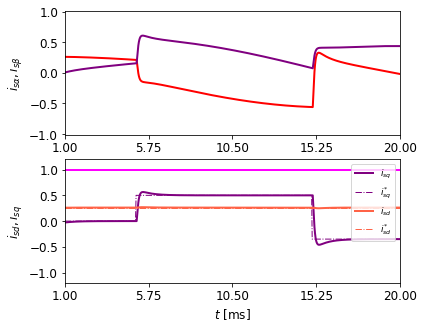

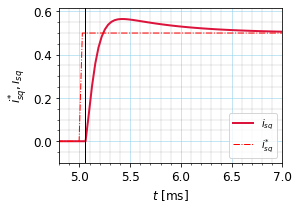

In [13]:
dirfig = "D:/tex/lec/drives/figures/"
dirfig2 = "D:/tex/lec/drives/Drivesbook/figures/"
plt.figure(531, figsize = (6,5))
plt.rc('font', size = 12)
plt.subplot(2,1,1)
plt.plot(rt/1e-3,  isa, 'r',lw =2) 
plt.plot(rt/1e-3,isb ,'purple' ,lw =2)
# plt.plot(rt, psra, 'skyblue')
t1w = 1e-3#np.pi*2*45
t2w = 20e-3#tend#7e-3#np.pi*2*60
plt.xlim(t1w/1e-3,t2w/1e-3)
plt.ylim(-1.01,1.01)
plt.xticks(np.linspace(t1w/1e-3,t2w/1e-3,5))
plt.ylabel(r'$i_{s\alpha}, \i_{s\beta}$' )
# plt.xticks(np.linspace(t1w,t2w,5))
ax1 = plt.subplot(2,1,2)
ax1.plot(rt/1e-3, isq, 'purple', lw =2, label = r'$i_{sq}$')
# ax1.plot(rt/1e-3, eiq, 'r', lw =1, label = r'$e_{sq}$')
ax1.plot(rt/1e-3,isqref,ls="-.", c= 'purple', lw =1, label = r'$i^{*}_{sq}$')
ax1 = plt.subplot(2,1,2)
ax1.plot(rt/1e-3, isd, 'tomato', lw =2, label = r'$i_{sd}$')
ax1.plot(rt/1e-3,isdref,ls="-.", c= 'tomato', lw =1, label = r'$i^{*}_{sd}$')
ax1.plot(rt/1e-3,psird, 'magenta', lw=2)
ax1.set_ylabel(r'$i_{sd}, \i_{sq}$' )
ax1.set_xlabel(r'$t$ [ms]')

plt.rcParams['legend.fontsize']=9
ax1.legend(loc = 'upper right')

# ax1.axhline(0, c = 'k')
#pl.axhline(-1.0)

# t1w = 0#np.pi*2*45
# t2w = tend#np.pi*2*60
ax1.set_xlim(t1w/1e-3,t2w/1e-3)
ax1.set_xticks(np.linspace(t1w/1e-3,t2w/1e-3,5))
# ax1.set_yticks(np.linspace(-0.5,1.0,4))
ax1.set_ylim(-1.2,1.2)
# ax2.set_ylim(0,3.14)
#Change name
# plt.savefig(dirfig2 + "FOCcurrentsvst2.pdf", bbox_inches = 'tight', transparent = True)

plt.figure(5341, figsize = (4,2.85))
plt.plot(rt/1e-3, isq, 'crimson', lw =2, label = r'$i_{sq}$')
# ax1.plot(rt/1e-3, eiq, 'r', lw =1, label = r'$e_{sq}$')
plt.plot(rt/1e-3,isqref,ls="-.", c= 'r', lw =1, label = r'$i^{*}_{sq}$')
t1w = 4.8e-3#np.pi*2*45
t2w = 7e-3#tend#7e-3#np.pi*2*60
plt.xlim(t1w/1e-3,t2w/1e-3)
plt.ylim(-0.1)
plt.ylabel(r'$i^{*}_{sq}, \i_{sq}$' )
plt.xlabel(r'$t$ [ms]')
plt.legend(loc = 'lower right', fontsize = 10)
plt.minorticks_on()
plt.grid(which = 'major', c = 'skyblue', lw = 0.5)
plt.grid(which = 'minor', c = 'grey', lw = 0.2)
plt.axvline(5.0512, c ='k', lw = 1.0)
plt.show()

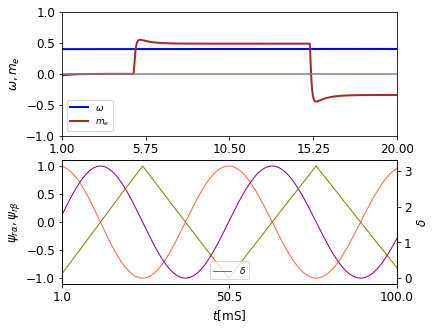

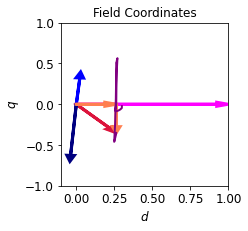

0.26247100277617025 -0.3499509531071158


In [14]:
plt.figure(535, figsize = (6,5))
plt.rc('font', size = 12)
plt.subplot(2,1,1)
plt.plot(rt/1e-3,  w, 'b', lw =2, label = '$\omega$')
plt.plot(rt/1e-3,me1 ,'brown' ,lw =2, label = '$m_e$')
t1w = 1e-3#np.pi*2*45
t2w = 20e-3#tend#7e-3#np.pi*2*60
plt.xlim(t1w/1e-3,t2w/1e-3)
# plt.xlim(0,tend)
plt.axvline(942.5)
plt.axhline(0, c= 'gray')
plt.ylabel(r'$\omega, m_e$' )
plt.xticks(np.linspace(t1w/1e-3,t2w/1e-3,5))
plt.yticks(np.linspace(-1.0,1.0,5))
plt.rcParams['legend.fontsize']=9
plt.legend(loc = 'lower left')

ax1 = plt.subplot(2,1,2)
ax1.plot(rt/1e-3,psra, 'tomato', lw =1, label = r'$i_{sd}$')
ax1.plot(rt/1e-3,psrb, 'purple', lw =1, label = r'$i_{sq}$')
# ax1.plot(rt1/e-3,psird, 'magenta', lw=2)
ax1.set_ylabel(r'$\psi_{r\alpha}, \psi_{r\beta}$' )
ax1.set_xlabel(r'$t$[mS]')
ax2 = ax1.twinx()
ax2.plot(rt/1e-3,FCangle, 'olive', lw =1, label = '$\delta$')
ax2.set_ylabel(r'$\delta$' )
plt.rcParams['legend.fontsize']= 9 
ax2.legend(loc = 'lower center')
t1w = 1e-3
t2w = 100e-3
ax1.set_xlim(t1w/1e-3,t2w/1e-3)
ax1.set_xticks(np.linspace(t1w/1e-3,t2w/1e-3,3))
# ax1.set_yticks(np.linspace(-1.0,1.0,5))
# ax1.set_ylim(-1.05,1.05)
# ax2.set_ylim(0,3.14)

# plt.savefig(dirfig2 + "FOCcSpeedTorquesvst2.pdf", bbox_inches = 'tight', transparent = True)



plt.figure(533, figsize = (3,3))
plt.rc('font', size = 12)
plt.rcParams['axes.titlesize']=12
plt.plot(isd,isq,'purple', lw =2, label = 'Field currents')
# plt.plot(usd, usq, 'skyblue', lw =2 , label = "Voltage")
# plt.axhline(0)
#plt.axvline(0)
plt.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
plt.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
plt.arrow(0,0,usd[-1],usq[-1], fc = 'navy', ec = 'navy',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
plt.arrow(0,0,usd[1000],usq[1000], fc = 'blue', ec = 'blue',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
plt.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
plt.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
# plt.text(psird[-1]-0.1, psirq[-1]+0.08, r'$\vec{\psi}_r$', fontsize = 16)
# plt.text(isd[-1], isq[-1]-0.09, r'$\vec{i}_{s}$', fontsize = 16)
# plt.text(usd[-1], usq[-1]-0.09, r'$\vec{v}_{s}$', fontsize = 16)
plt.xlabel(r'$d$')
plt.ylabel(r'$q$')
plt.xlim(-0.1,1.0)
plt.ylim(-1.0,1.0)
plt.xticks(np.linspace(0,1.0,5))
# plt.axis('equal')
plt.rcParams['legend.fontsize']=9
# plt.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
plt.title('Field Coordinates')
#Change name
# plt.savefig(dirfig2 + "FOCcXYvectors2.pdf", bbox_inches = 'tight', transparent = True)
plt.show()
print(isd[-1], isq[-1])

## Fluxing (Creating initial flux) and inner current control 

In [39]:
tend = 5#s
tinc = 3.183098861837907e-05
rt = np.arange(0,tend,tinc)
#Solution variables and control variab;es
u = np.zeros((len(rt),2)) #array for the voltage - u[0][0] - vsalpha(0) u[0][1] - vsbeta(0)
mla = np.zeros(len(rt))  #load torque array
soln = np.zeros((len(rt),5)) #array to store the solution values 
solm = np.zeros((len(rt),2))
print(len(rt), len(u), len(mla), len(soln))
print(np.shape(u))

157080 157080 157080 157080
(157080, 2)


In [40]:
T_s = 3.183098861837907e-05#512e-6#sampling time
########-----------------------------------
V_LL = 400#V
Vpnpeak = np.sqrt(2)*V_LL/np.sqrt(3)
I_LL = 10.4#A
V_DC = np.sqrt(2)*V_LL#V Peak value of line to line voltage
print("V_DC", V_DC)
T_eq = 1.5*T_s
# T_eq = T_s
#Normalized time constant
tau_eq = T_eq*w_R
k_c = V_DC/(2*Vpnpeak)
#
k_is = 1/rk
k_im = k_c*1/rk
# k_im = 1.0#test
ac = 4.0
#T_i = tk
T_i = tau_eq*ac**2
print(tk, tau_eq, k_im)
#k_pi = tk/(2*k_im*tau_eq)
k_pi = tk/(0.8*ac*k_im*tau_eq)
# k_pi = 0.5
# T_i = 100.0
print(ac,tk,tau_eq)
Kparams = [k_pi,T_i]
Kparams2 = [k_pi,T_i, -1.0,1.0]
print(k_pi, T_i, k_im)
rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)

V_DC 565.685424949238
5.721404205248259 0.015 27.848447052241013
4.0 5.721404205248259 0.015
4.280164014857703 0.24 27.848447052241013


In [41]:

usa = np.zeros(len(rt))
usb = np.zeros(len(rt))
sol1 = np.zeros((len(rt),5))
sol2 = np.zeros((len(rt),2))
FCangle = np.zeros(len(rt))
# Field coordinate currents
cosdelta = np.zeros(len(rt))
sindelta = np.zeros(len(rt))
isd = np.zeros(len(rt))
isq = np.zeros(len(rt))
usd = np.zeros(len(rt))
usq = np.zeros(len(rt))
eid = np.zeros(len(rt))
eiq = np.zeros(len(rt))
psirref = np.zeros(len(rt))

#Creating reference values for isd and isq
isdrefval = 1/lh
isdref = np.zeros(len(rt))
isqref = np.zeros(len(rt))
psirval = 1.0
isqref1 = 0
isqref2 = 0.5
isqref3 = -0.35
for ii, item in enumerate(rt):
    if (item >= 3):
        isqref[ii] = isqref3
        psirref[ii] = psirval
    elif(item >= 2):
        isqref[ii]= isqref2
        psirref[ii] = psirval
    elif(item >= 0.5e-3):
         psirref[ii] = psirval
    else:
        isqref[ii]=isqref1




psird = np.zeros(len(rt))
psirq = np.zeros(len(rt))

mL = 0.0
me = np.zeros(len(rt))
# x0 = [0.0,0.0,1.0,0,ws]
rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)

epsir = np.zeros(len(rt)) #error in flux controller
ew = np.zeros(len(rt))    #error in speed controller

kpf = 10.2
Tif = 1.0e1
# Kparams2 = [k_pi,T_i, -1.0,1.0]
KfluxcontrolLim = [kpf,Tif,0.8,0]
Kfluxcontrol = [kpf,Tif]
X0 = [0.0,0.0,0.0,0.0,ws] #setting the inital conditions 
X0m = [0.0,0] 

In [42]:
ws = 0.1
X0 = [0.1,0.0,0.0,0.0,ws] #setting the inital conditions 
X0m = [0.1,0] 
for ii, tnow in enumerate(rt):
    #Start controller after first step
    psird[0]=0.0
    if ii > 0:
        #-------------------------------------------
        #flux controller
        epsir[ii] = psirref[ii-1] - psird[ii-1]
        PIpsr = [epsir[ii], epsir[ii-1]]
#         isdref[ii] = PIcon(PIpsr,isdref[ii-1], w_R*tinc, Kfluxcontrol)
        isdref[ii] = PIconwithLim(PIpsr,isdref[ii-1], w_R*tinc, KfluxcontrolLim)
        #---------------------------------------------------------------
        eid[ii] = isdref[ii-1] - isd[ii-1]
        PIed = [eid[ii],eid[ii-1]]
        usd[ii] = PIcon(PIed, usd[ii-1], w_R*tinc,Kparams) #+ ws*sig*ls*isq[ii-1]
#         usd[ii] = PIconwithLim(PIed,usd[ii-1],tinc,Kparams2)
        eiq[ii] = isqref[ii-1] - isq[ii-1]
        PIeq = [eiq[ii],eiq[ii-1]]
        usq[ii] = PIcon(PIeq, usq[ii-1], tinc,Kparams) #- ws*sig*ls*isd[ii-1]
#         usq[ii] = PIconwithLim(PIeq,usq[ii-1],tinc,Kparams2)
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
    #vector control transformation 
    usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
    usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]
    #------------------------------------------------------------------------------------
    #Model of the induction motor full
    params = [usa[ii],usb[ii],0,rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech] #desired frequency , voltage components, load torque
    #call odeint(dydt, Initial condition, [0,tinc], parameters)
    solx = odeint(Im_dynamic,X0, [0,w_R*tinc], args = (params,), atol = abserr, rtol = relerr)
    X0 = solx[-1] #
    sol1[ii] = solx[-1] #
    # lh,tr,w,isa,isb
    #estimator uses only the variables that I can measure
    paramsmodel = [lh,tr,sol1[ii,4],sol1[ii,0],sol1[ii,1],]
    soly = odeint(rotor_model,X0m, [0,w_R*tinc], args = (paramsmodel,), atol = abserr, rtol = relerr)
    X0m = soly[-1]
    sol2[ii] = soly[-1]
    #----------------------------------------
    psircomp = complex(sol2[ii][0], sol2[ii][1])
    FCangle[ii] = cmath.phase(psircomp)#np.arccos(sol2[ii][0]/np.abs(psircomp))
    cosdelta[ii] = sol2[ii][0]/np.abs(psircomp)
    sindelta[ii] = sol2[ii][1]/np.abs(psircomp)
    #Coordinate transformation 
    #Convert stator coordinate current to field coordinates
    isd[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
    isq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
    psird[ii] = sol2[ii][0]*cosdelta[ii] + sol2[ii][1]*sindelta[ii]
    psirq[ii] = sol2[ii][1]*cosdelta[ii] - sol2[ii][0]*sindelta[ii]

    
isa = sol1[:, 0]
isb = sol1[:, 1]
psra = sol1[:, 2]
psrb = sol1[:, 3]
w = sol1[:,4]
psiradash = sol2[:,0]
psirbdash = sol2[:,1]



me1 = kr*(psra*isb - psrb*isa)

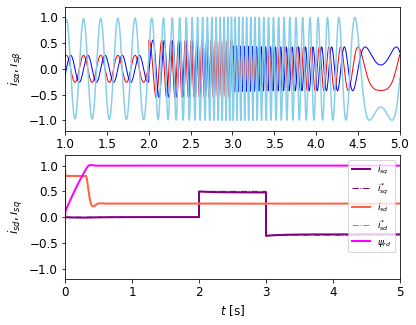

In [43]:
dirfig = "D:/tex/lec/drives/figures/"
dirfig2 = "D:/tex/lec/drives/Drivesbook/figures/"
plt.figure(531, figsize = (6,5))
plt.rc('font', size = 12)
plt.subplot(2,1,1)
plt.plot(rt,  isa, 'r',lw =1) 
plt.plot(rt,isb ,'blue' ,lw =1)
plt.plot(rt, psra, 'skyblue')
t1w = 1#np.pi*2*45
t2w = tend#7e-3#np.pi*2*60
plt.xlim(t1w,t2w)
plt.ylim(-1.2,1.2)
# plt.xticks(np.linspace(t1w/1e-3,t2w/1e-3,5))
plt.ylabel(r'$i_{s\alpha}, \i_{s\beta}$' )
# plt.xticks(np.linspace(t1w,t2w,5))
ax1 = plt.subplot(2,1,2)
ax1.plot(rt, isq, 'purple', lw =2, label = r'$i_{sq}$')
ax1.plot(rt,isqref,ls="-.", c= 'purple', lw =1, label = r'$i^{*}_{sq}$')
ax1 = plt.subplot(2,1,2)
ax1.plot(rt, isd, 'tomato', lw =2, label = r'$i_{sd}$')
ax1.plot(rt,isdref,ls="-.", c= 'tomato', lw =1, label = r'$i^{*}_{sd}$')
ax1.plot(rt,psird, 'magenta', lw=2, label= r"$\psi_{rd}$")
ax1.set_ylabel(r'$i_{sd}, \i_{sq}$' )
ax1.set_xlabel(r'$t$ [s]')

plt.rcParams['legend.fontsize']=9
ax1.legend(loc = 'upper right')

# ax1.axhline(0, c = 'k')
#pl.axhline(-1.0)

# t1w = 0#np.pi*2*45
# t2w = tend#np.pi*2*60
# ax1.set_xlim(t1w/1e-3,t2w/1e-3)
ax1.set_xlim(0,t2w)
# ax1.set_xticks(np.linspace(t1w/1e-3,t2w/1e-3,5))
# ax1.set_yticks(np.linspace(-0.5,1.0,4))
ax1.set_ylim(-1.2,1.2)
# ax2.set_ylim(0,3.14)
#Change name
# plt.savefig(dirfig2 + "FOCcurrentsvst2.pdf", bbox_inches = 'tight', transparent = True)
plt.show()

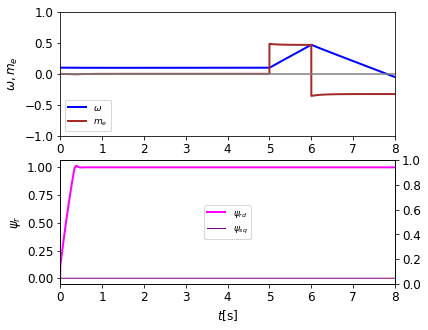

In [38]:
plt.figure(536, figsize = (6,5))
plt.rc('font', size = 12)
plt.subplot(2,1,1)
plt.plot(rt,  w, 'b', lw =2, label = '$\omega$')
plt.plot(rt,me1 ,'brown' ,lw =2, label = '$m_e$')
t1w = 0#np.pi*2*45
t2w = tend#7e-3#np.pi*2*60
# plt.xlim(t1w/1e-3,t2w/1e-3)
plt.xlim(0,t2w)
plt.axvline(942.5)
plt.axhline(0, c= 'gray')
plt.ylabel(r'$\omega, m_e$' )
# plt.xticks(np.linspace(t1w/1e-3,t2w/1e-3,5))
plt.yticks(np.linspace(-1.0,1.0,5))
plt.rcParams['legend.fontsize']=9
plt.legend(loc = 'lower left')

ax1 = plt.subplot(2,1,2)
ax1.plot(rt,psird, 'magenta', lw=2, label= r"$\psi_{rd}$")
ax1.plot(rt,psirq, 'purple', lw =1, label = r'$\psi_{sq}$')
# ax1.plot(rt1/e-3,psird, 'magenta', lw=2)
ax1.set_ylabel(r'$\psi_{rd}, \psi_{rq}$' )
ax1.set_xlabel(r'$t$[s]')
ax2 = ax1.twinx()
# ax2.plot(rt/1e-3,FCangle, 'olive', lw =1, label = '$\delta$')
ax1.set_ylabel(r'$\psi_r$' )
plt.rcParams['legend.fontsize']= 9 
ax1.legend(loc = 'center')
t1w = 0
t2w = tend
# ax1.set_xlim(t1w/1e-3,t2w/1e-3)
# ax1.set_xticks(np.linspace(t1w/1e-3,t2w/1e-3,3))
# ax1.set_yticks(np.linspace(-1.0,1.0,5))
# ax1.set_ylim(-1.05,1.05)
# ax2.set_ylim(0,3.14)
ax1.set_xlim(0,t2w)
plt.show()

#### Speed Control

Try to build one for the speed controller